# **5MIN OMNI & OCB Model**

**Author:** Arnav Singh 
**Date:** 2024-08-21

---

## **Abstract**

For this notebook, the 5MIN merged OMNI dataset will be used to create different models attempting to model the OCB locations with various inputs and models. 

## **Keywords**

- Keyword 1
- Keyword 2
- Keyword 3

---

## **Table of Contents**

1. [Introduction](#introduction)
2. [Data Description](#data-description)
3. [Data Preprocessing](#data-preprocessing)
4. [Exploratory Data Analysis](#exploratory-data-analysis)
5. [Feature Engineering](#feature-engineering)
6. [Model Selection](#model-selection)
7. [Model Training](#model-training)
8. [Model Evaluation](#model-evaluation)
9. [Hyperparameter Tuning](#hyperparameter-tuning)
10. [Results and Discussion](#results-and-discussion)
11. [Conclusion](#conclusion)
12. [References](#references)
13. [Appendix](#appendix)

---

## **Introduction**

Introduce the problem statement, background information, and the significance of the modeling project.

---

In [1]:
## Necessary Imports ##
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, regularizers
import keras_tuner as kt

# For mapping
try:
    import cartopy.crs as ccrs
    import cartopy.feature as cfeature
    CARTOPY_AVAILABLE = True
except ImportError:
    CARTOPY_AVAILABLE = False

In [2]:
# -------------------------------------
# Load and Preprocess Data
# -------------------------------------
# large data (~480k rows), directly load:
df = pd.read_parquet('data/5minData.parquet')
df.describe()

,b1e_date,b1e_geo_lat,b1e_geo_long,b1e_mag_lat,b1e_mag_long,b1e_mlt,b2e_date,b2e_geo_lat,b2e_geo_long,b2e_mag_lat,...,PROTON_DENSITY_n/cc,FLOW_PRESSURE_nPa,5-M_AE_nT,5-M_AL-INDEX_nT,SYM/H_INDEX_nT,5-M_PC(N)-INDEX_,BT,qc,sin_term,dFMP_dt
count,483943,483943.000000,483943.000000,483943.000000,483943.000000,483943.000000,483943,483943.000000,483943.000000,483943.000000,...,483943.000000,483943.000000,483943.000000,483943.000000,483943.000000,483943.000000,483943.000000,483943.000000,242034.000000,242034.000000
mean,2002-10-31 14:23:44.453725312,-15.572451,178.765413,-15.990386,13.539736,14.965626,2002-10-18 09:01:19.679699712,-16.511905,176.348897,-16.722341,...,6.743317,2.361047,215.201666,-136.636346,-13.517668,1.143528,4.713087,-0.016267,0.448816,4203.285129
min,1982-12-31 23:59:59,-81.520000,0.000000,-87.450000,-180.000000,0.000000,1982-12-31 23:59:59,-81.520000,0.000000,-89.660000,...,0.090000,0.020000,2.000000,-3032.000000,-475.000000,-16.220000,0.010000,-3.141593,0.000000,0.000000
25%,1998-07-09 17:40:21.500000,-68.110000,80.950000,-66.870000,-64.675000,6.670000,1998-06-20 16:40:46.500000,-71.170000,79.490000,-67.860000,...,3.350000,1.340000,54.000000,-191.000000,-21.000000,0.200000,2.643728,-1.654680,0.137650,1002.907335
50%,2003-05-20 15:01:22,-52.090000,169.140000,-62.050000,24.880000,18.230000,2003-05-10 10:12:01,-53.900000,166.770000,-63.960000,...,5.200000,1.920000,129.000000,-70.000000,-10.000000,0.810000,4.062032,0.000000,0.417797,3017.425966
75%,2007-08-25 17:40:04.500000,61.290000,283.840000,65.270000,90.290000,20.300000,2007-08-12 21:35:19,62.820000,278.240000,66.630000,...,8.300000,2.790000,302.000000,-24.000000,-2.000000,1.810000,5.928912,1.610380,0.744907,5934.565018
max,2012-12-31 22:34:38,81.510000,360.000000,88.210000,180.000000,24.000000,2012-12-31 22:19:20,81.520000,360.000000,89.500000,...,71.440000,89.510000,3274.000000,41.000000,97.000000,29.080000,56.373543,3.141593,1.000000,120906.366746
std,NaN,62.045432,110.172856,63.470798,97.254654,6.855460,NaN,63.820807,109.406169,65.150619,...,5.383610,1.838813,227.164017,169.071431,20.911351,1.457352,3.188698,1.805485,0.330131,4580.793781


Now that is a lot of potential parameters for our model, but we can test which combinations work well with the models.

In [3]:
features = [
    'BY__GSM_nT', 'BZ__GSM_nT', 'FLOW_SPEED__GSE_km/s', 'PROTON_DENSITY_n/cc', 
    'FLOW_PRESSURE_nPa', '5-M_AE_nT', '5-M_AL-INDEX_nT', 'SYM/H_INDEX_nT', 
    '5-M_PC(N)-INDEX_', 'BT', 'qc', 'dFMP_dt'
]

target_lat = 'b6_mag_lat'
target_lon = 'b6_mag_long'

# Drop rows with missing data
df = df.dropna(subset=features + [target_lat, target_lon])

X = df[features].values
Y = df[[target_lat, target_lon]].values

# Train-validation-test split
X_trainval, X_test, Y_trainval, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
X_train, X_val, Y_train, Y_val = train_test_split(X_trainval, Y_trainval, test_size=0.25, random_state=42)
# 60% train, 20% dev, 20% test

# Scale inputs
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

Reloading Tuner from tuner_dir/ocb_prediction/tuner0.json
Best hyperparameters: {'num_layers': 3, 'units': 192, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'l2_reg': 1e-05}
Epoch 1/200
1135/1135 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 6821.6284 - mae: 73.9042 - val_loss: 6763.3101 - val_mae: 73.1077
Epoch 2/200
1135/1135 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 6747.1592 - mae: 73.1251 - val_loss: 6757.7988 - val_mae: 73.3549
Epoch 3/200
1135/1135 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 6731.1675 - mae: 72.9929 - val_loss: 6751.5874 - val_mae: 73.2156
Epoch 4/200
1135/1135 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 6762.8130 - mae: 73.1728 - val_loss: 6758.6958 - val_mae: 73.7652
Epoch 5/200
1135/1135 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 6751.5879 - mae: 73.0598 - val_loss: 6753.4438 - val_mae: 73.5040
Epoch 6/200
1135/1135 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 6704.7368 - mae: 72.7848 - val_loss: 6748.2783 - val_mae: 73.2037
Epoch 7/200
1135/1135 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/st

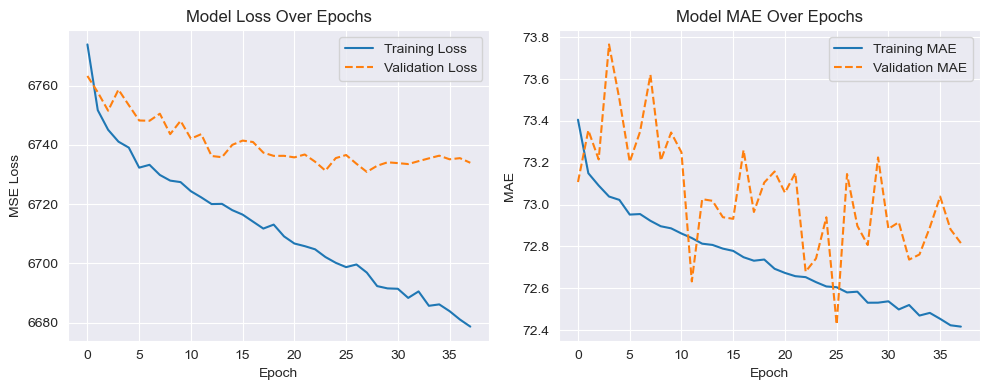

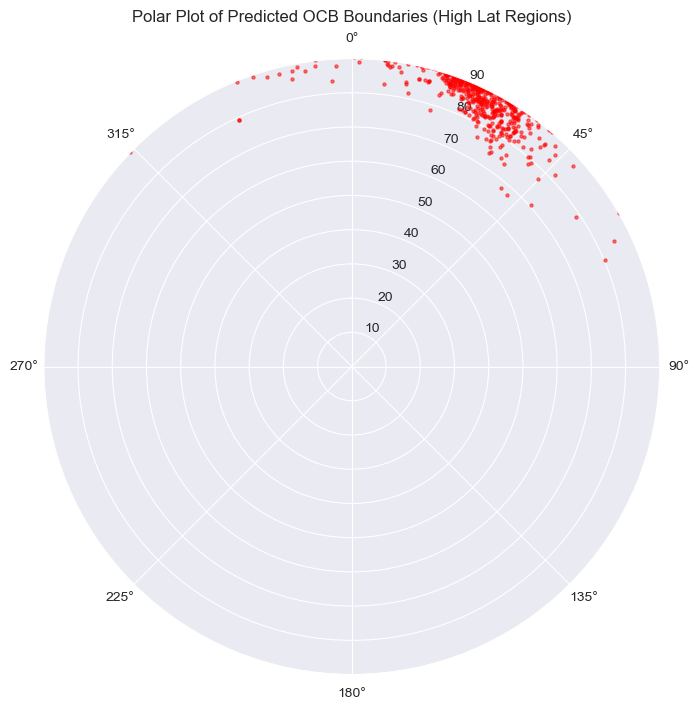

Cartopy not installed, skipping global map plot.


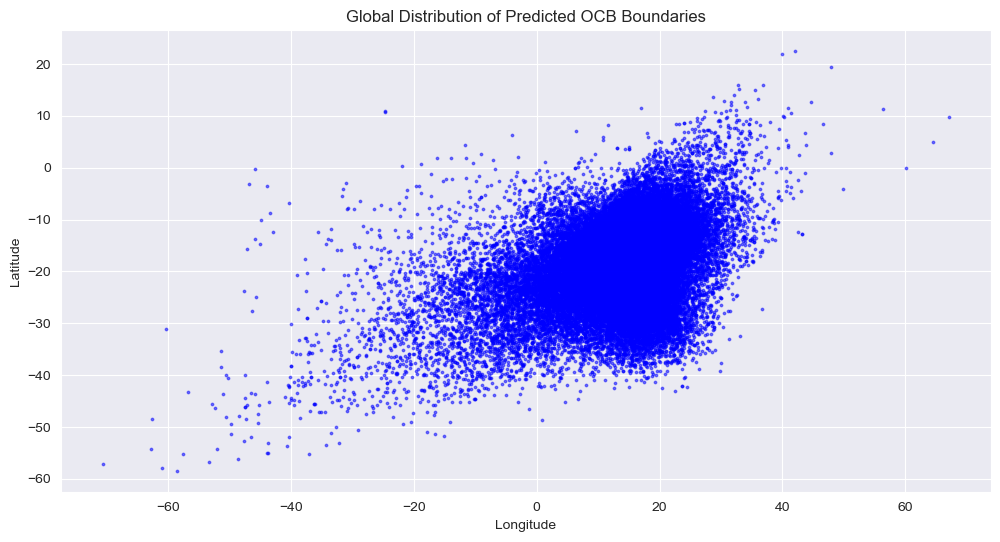

In [4]:
# -------------------------------------
# Hyperparameter Tuning for Neural Network
# -------------------------------------
def build_model(hp):
    # Tune number of layers, units, dropout rate, and learning rate
    num_layers = hp.Int('num_layers', 1, 3)
    units = hp.Int('units', min_value=64, max_value=256, step=64)
    dropout_rate = hp.Float('dropout_rate', 0.0, 0.5, step=0.1)
    learning_rate = hp.Choice('learning_rate', [1e-3, 5e-4, 1e-4])
    l2_reg = hp.Choice('l2_reg', [0.0, 1e-5, 1e-4, 1e-3])

    model = models.Sequential()
    model.add(layers.Input(shape=(X_train.shape[1],)))
    for _ in range(num_layers):
        model.add(layers.Dense(units, activation='relu', 
                               kernel_regularizer=regularizers.l2(l2_reg)))
        if dropout_rate > 0.0:
            model.add(layers.Dropout(dropout_rate))
    model.add(layers.Dense(2))

    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    return model

tuner = kt.RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=10,  # can increase if you want more extensive search
    executions_per_trial=1,
    directory='tuner_dir',
    project_name='ocb_prediction'
)

es_tune = callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
tuner.search(X_train, Y_train, epochs=20, validation_data=(X_val, Y_val), callbacks=[es_tune], verbose=1)

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print("Best hyperparameters:", best_hps.values)

# Build the best model
model = tuner.hypermodel.build(best_hps)

# Final training with early stopping to prevent overfitting
es = callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(X_train, Y_train,
                    validation_data=(X_val, Y_val),
                    epochs=200,
                    batch_size=128,
                    callbacks=[es],
                    verbose=1)

# Evaluate the Model
test_loss, test_mae = model.evaluate(X_test, Y_test, verbose=0)
print(f"Neural Network Test MSE: {test_loss:.3f}, Test MAE: {test_mae:.3f}")

# Predictions from neural network
nn_preds = model.predict(X_test)

# -------------------------------------
# Test Other ML Methods (KNN, RandomForest) for Comparison
# -------------------------------------
knn_params = {'n_neighbors': [3,5,7], 'weights': ['uniform', 'distance']}
knn = KNeighborsRegressor()
knn_grid = GridSearchCV(knn, knn_params, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
knn_grid.fit(X_train, Y_train)
best_knn = knn_grid.best_estimator_

knn_test_preds = best_knn.predict(X_test)
knn_mse = mean_squared_error(Y_test, knn_test_preds)
knn_mae = mean_absolute_error(Y_test, knn_test_preds)
print(f"KNN Test MSE: {knn_mse:.3f}, Test MAE: {knn_mae:.3f}")

rf_params = {'n_estimators': [50, 100], 'max_depth': [None, 20]}
rf = RandomForestRegressor(random_state=42, n_jobs=-1)
rf_grid = GridSearchCV(rf, rf_params, cv=3, scoring='neg_mean_squared_error')
rf_grid.fit(X_train, Y_train)
best_rf = rf_grid.best_estimator_

rf_test_preds = best_rf.predict(X_test)
rf_mse = mean_squared_error(Y_test, rf_test_preds)
rf_mae = mean_absolute_error(Y_test, rf_test_preds)
print(f"Random Forest Test MSE: {rf_mse:.3f}, Test MAE: {rf_mae:.3f}")

# -------------------------------------
# Visualizing the Neural Network Training
# -------------------------------------
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss', linestyle='--')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE', linestyle='--')
plt.title('Model MAE Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()

plt.tight_layout()
plt.show()

# -------------------------------------
# Visualizing the Predictions
# -------------------------------------
# We have predictions from the neural network: nn_preds
pred_lats = nn_preds[:,0]
pred_lons = nn_preds[:,1]

# Let's do a polar plot focusing on high-latitude regions.
# For polar plot, convert latitude to colatitude:
r = 90.0 - pred_lats  # so that near 90N = radius ~0, and 0 lat = radius=90.
theta = np.deg2rad(pred_lons)  # convert longitude to radians

fig = plt.figure(figsize=(8,8))
ax = plt.subplot(111, polar=True)
ax.scatter(theta, r, s=5, alpha=0.5, c='red')
ax.set_theta_zero_location('N')  # North at top
ax.set_theta_direction(-1)       # increase clockwise
ax.set_rmax(90)
ax.set_title("Polar Plot of Predicted OCB Boundaries (High Lat Regions)", va='bottom')
plt.show()

# Additionally, let's make a global map plot (if cartopy is available)
if CARTOPY_AVAILABLE:
    fig = plt.figure(figsize=(12,6))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.add_feature(cfeature.LAND, edgecolor='black', alpha=0.3)
    ax.add_feature(cfeature.OCEAN, alpha=0.3)
    ax.add_feature(cfeature.COASTLINE)
    ax.set_global()
    ax.gridlines(draw_labels=True)
    
    # Scatter the predictions around the globe
    # If these boundaries are global, we can show their locations:
    sc = ax.scatter(pred_lons, pred_lats, c='blue', s=3, alpha=0.5, transform=ccrs.PlateCarree())
    plt.title("Global Map of Predicted OCB Boundaries")
    plt.show()
else:
    print("Cartopy not installed, skipping global map plot.")

# If cartopy isn't available, you can do a basic world map using a simple projection in matplotlib:
# Example without cartopy (just a scatter plot with lat/lon):
plt.figure(figsize=(12,6))
plt.scatter(pred_lons, pred_lats, c='blue', s=3, alpha=0.5)
plt.title("Global Distribution of Predicted OCB Boundaries")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()



Epoch 1/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 309.1500 - mae: 11.4380 - val_loss: 27.7778 - val_mae: 4.0660
Epoch 2/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 33.0833 - mae: 4.4764 - val_loss: 16.4535 - val_mae: 3.0517
Epoch 3/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 23.6684 - mae: 3.7754 - val_loss: 15.7861 - val_mae: 2.9693
Epoch 4/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 20.5192 - mae: 3.5029 - val_loss: 15.1897 - val_mae: 2.9354
Epoch 5/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 19.1452 - mae: 3.3819 - val_loss: 15.9389 - val_mae: 3.0044
Epoch 6/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 18.3871 - mae: 3.2913 - val_loss: 15.1355 - val_mae: 2.9216
Epoch 7/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 17.6332 - mae: 3.2237 - val_loss: 14.4602 - val_mae: 2.8436
Epoch 8/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 17.3621 - mae: 3.1888 - val_loss: 14.0894 - val_mae: 2.8214
Epoch 9/100
413/413 ━━━━━━━━━━

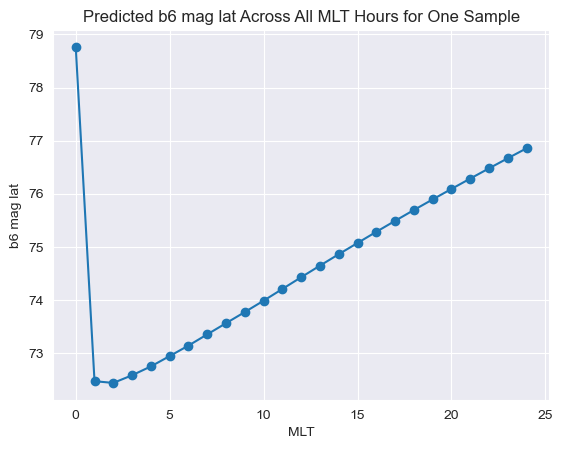

In [13]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, regularizers

# -------------------------------------
# Load Data
# -------------------------------------
df = pd.read_parquet('data/5minData.parquet')
Northern = df['b6_mag_lat'] > 0
Southern = df['b6_mag_lat'] < 0
North_df = df[Northern]
South_df = df[Southern]
def NeuralNetwork(df):
    features = [
        'BY__GSM_nT', 'BZ__GSM_nT', 'FLOW_SPEED__GSE_km/s', 'PROTON_DENSITY_n/cc', 
        'FLOW_PRESSURE_nPa', '5-M_AE_nT', 'dFMP_dt', 'b6_mlt'
    ]
    
    target = 'b6_mag_lat'  # single latitude per MLT
    
    df = df.dropna(subset=features + [target])
    
    X = df[features].values
    Y = df[[target]].values  # shape (N, 1)
    
    # Train-validation-test split
    X_trainval, X_test, Y_trainval, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
    X_train, X_val, Y_train, Y_val = train_test_split(X_trainval, Y_trainval, test_size=0.25, random_state=42)
    
    # Scale inputs
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_val = scaler.transform(X_val)
    X_test = scaler.transform(X_test)
    
    # -------------------------------------
    # Build the Model (single MLT input)
    # -------------------------------------
    model = models.Sequential([
        layers.Input(shape=(X_train.shape[1],)),
        layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(1e-4)),
        layers.Dropout(0.2),
        layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(1e-4)),
        layers.Dropout(0.2),
        # Force output to be in [-90, 90]
        layers.Dense(1, activation='tanh'),        # now in [-1, 1]
        layers.Lambda(lambda x: x * 90.0),  # scale to [-90, 90]
    ])
    
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    
    es = callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    history = model.fit(X_train, Y_train,
                        validation_data=(X_val, Y_val),
                        epochs=100,
                        batch_size=128,
                        callbacks=[es],
                        verbose=1)
    
    test_loss, test_mae = model.evaluate(X_test, Y_test, verbose=0)
    print(f"Test MSE: {test_loss:.3f}, Test MAE: {test_mae:.3f}")
    
    # -------------------------------------
    # Predicting all MLT latitudes at a given time
    # -------------------------------------
    # Suppose you have a set of conditions at a particular instant in time (from the test set)
    example_input_features = X_test[0:1]  # one sample
    # This corresponds to some MLT in example_input_features[-1], but we can vary MLT now.
    
    # Extract everything except the last feature (b6_mlt) if it is last in your feature list
    # If 'b6_mlt' is the last feature in the feature list, do:
    base_features = example_input_features.copy()
    
    # Let's say the last column of features is MLT:
    feature_idx_mlt = features.index('b6_mlt')
    for_mlt_prediction = np.tile(base_features, (25,1)) # 25 rows for MLT=0 to 24
    # Vary MLT from 0 to 24
    mlt_values = np.arange(25)
    for_mlt_prediction[:, feature_idx_mlt] = mlt_values
    
    # Predict for each MLT
    all_mlt_predictions = model.predict(for_mlt_prediction)
    all_mlt_predictions = all_mlt_predictions.flatten()
    
    # Plot the latitude vs. MLT
    plt.plot(mlt_values, all_mlt_predictions, marker='o')
    plt.title("Predicted b6 mag lat Across All MLT Hours for One Sample")
    plt.xlabel("MLT")
    plt.ylabel("b6 mag lat")
    plt.grid(True)
    plt.show()

NeuralNetwork(North_df)

In [ ]:
NeuralNetwork(South_df)

Epoch 1/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.1110 - loss: 2.9958 - val_accuracy: 0.1338 - val_loss: 2.6730
Epoch 2/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.1382 - loss: 2.6617 - val_accuracy: 0.1421 - val_loss: 2.6201
Epoch 3/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.1416 - loss: 2.6145 - val_accuracy: 0.1413 - val_loss: 2.5923
Epoch 4/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.1473 - loss: 2.5785 - val_accuracy: 0.1494 - val_loss: 2.5695
Epoch 5/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.1503 - loss: 2.5623 - val_accuracy: 0.1487 - val_loss: 2.5540
Epoch 6/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.1518 - loss: 2.5595 - val_accuracy: 0.1512 - val_loss: 2.5563
Epoch 7/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.1501 - loss: 2.5566 - val_accuracy: 0.1547 - val_loss: 2.5468
Epoch 8/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.1536 - loss: 2.5450 - val_acc

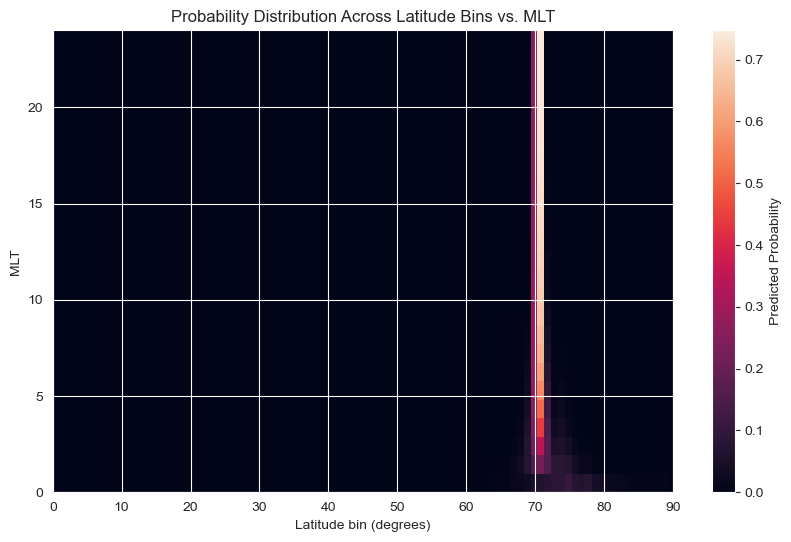

In [23]:
# -------------------------------------
# Load Data
# -------------------------------------
df = pd.read_parquet('data/5minData.parquet')
Northern = df['b6_mag_lat'] > 0
Southern = df['b6_mag_lat'] < 0
df = df[Northern]

features = [
    'BY__GSM_nT', 'BZ__GSM_nT', 'FLOW_SPEED__GSE_km/s', 'PROTON_DENSITY_n/cc', 
    'FLOW_PRESSURE_nPa', '5-M_AE_nT', 'dFMP_dt', 'b2i_mag_lat','b6_mlt'
]

target = 'b6_mag_lat'  # single latitude per MLT

df = df.dropna(subset=features + [target])

X = df[features].values
Y = df[[target]].values  # shape (N, 1)

# Train-validation-test split
X_trainval, X_test, Y_trainval, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
X_train, X_val, Y_train, Y_val = train_test_split(X_trainval, Y_trainval, test_size=0.25, random_state=42)

# Scale inputs
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# 181 evenly spaced integer latitudes from -90 to +90
lat_bins = np.arange(0, 91, 1)  # shape=(181,)
N_BINS = len(lat_bins)  # 181

# Suppose Y_train is shape (N,) with lat in range [-90, 90]
# We'll find the bin each lat belongs to via np.digitize
Y_train_bin = np.digitize(Y_train, lat_bins) - 1  
#   -1 so that bins start at index 0. 
#   This yields integer indexes in [0..180].

# We do the same for Y_val and Y_test
Y_val_bin = np.digitize(Y_val, lat_bins) - 1
Y_test_bin = np.digitize(Y_test, lat_bins) - 1

from tensorflow.keras.utils import to_categorical

#  Option A: "sparse" labels
#  Just use Y_train_bin as is (integer class labels).
#  Then compile with loss='sparse_categorical_crossentropy'.

model = models.Sequential([
    layers.Input(shape=(X_train.shape[1],)),
    layers.Dense(1024, activation='relu', kernel_regularizer=regularizers.l2(1e-4)),
    layers.Dropout(0.2),
    layers.Dense(1024, activation='relu', kernel_regularizer=regularizers.l2(1e-4)),
    layers.Dropout(0.2),
    layers.Dense(N_BINS, activation='softmax')  # 181-class output
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',  # use sparse labels
              metrics=['accuracy'])

history = model.fit(X_train, Y_train_bin,
                    validation_data=(X_val, Y_val_bin),
                    epochs=100, batch_size=128,
                    callbacks=[es],
                    verbose=1)

proba = model.predict(X_test)  # shape (N_test, 181)
# If you want the “most likely” latitude:
predicted_bin = np.argmax(proba, axis=1)  # integer in [0..180]
predicted_lat = lat_bins[predicted_bin]   # map bin index back to actual lat
example_input_features = X_test[0:1]  # one sample
# This corresponds to some MLT in example_input_features[-1], but we can vary MLT now.

# Extract everything except the last feature (b6_mlt) if it is last in your feature list
# If 'b6_mlt' is the last feature in the feature list, do:
base_features = example_input_features.copy()

# Let's say the last column of features is MLT:
feature_idx_mlt = features.index('b6_mlt')

MLT_values = np.arange(25)
prob_distributions = []

for mlt in MLT_values:
    # Make a copy of your features
    temp_input = base_features.copy()
    # Set the MLT column to this mlt
    temp_input[0, feature_idx_mlt] = mlt
    
    # Predict probabilities for this single input
    proba = model.predict(temp_input)  # shape = (1, 181)
    
    # proba is 2D; extract the 1D probability array
    prob_distributions.append(proba[0])

# Convert to a 2D array: shape = (25, 181)
#   row = MLT, col = latitude bin
prob_distributions = np.array(prob_distributions)


plt.figure(figsize=(10, 6))

# imshow expects (top->bottom, left->right), so we set extent properly
#   extent = (x_min, x_max, y_min, y_max)
#   Here x is lat_bins from -90..90, y is MLT from 0..24
plt.imshow(prob_distributions, 
           origin='lower',               # so that row 0 is at the bottom
           aspect='auto', 
           extent=(lat_bins[0], lat_bins[-1], MLT_values[0], MLT_values[-1]))

plt.colorbar(label="Predicted Probability")
plt.xlabel("Latitude bin (degrees)")
plt.ylabel("MLT")
plt.title("Probability Distribution Across Latitude Bins vs. MLT")
plt.show()


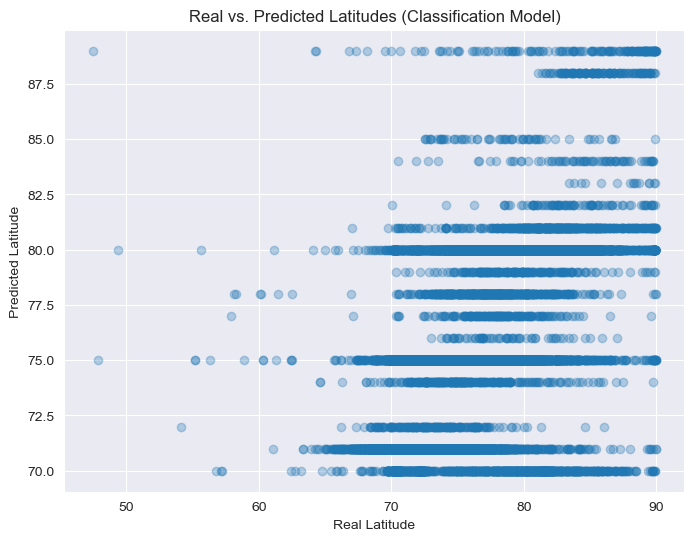

In [24]:
real_lat = Y_test.flatten()

plt.figure(figsize=(8,6))
plt.scatter(real_lat, predicted_lat, alpha=0.3)
plt.xlabel("Real Latitude")
plt.ylabel("Predicted Latitude")
plt.title("Real vs. Predicted Latitudes (Classification Model)")
plt.grid(True)
plt.show()


Other Models:


Training Linear Regression...
Best parameters for Linear Regression: {}

Training Ridge...
Best parameters for Ridge: {'alpha': 10.0}

Training Lasso...
Best parameters for Lasso: {'alpha': 0.1}

Training Random Forest...


/Users/beastxgamer/anaconda3/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best parameters for Random Forest: {'max_depth': 20, 'min_samples_split': 5, 'n_estimators': 200}

Training SVR...
Best parameters for SVR: {'C': 10.0, 'kernel': 'rbf'}


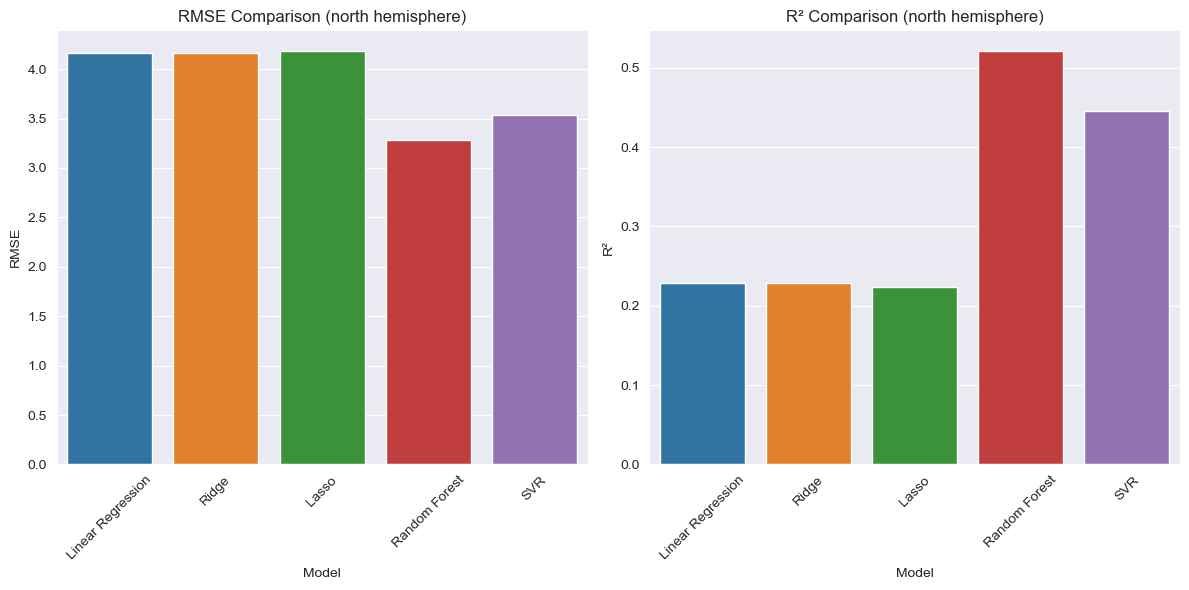

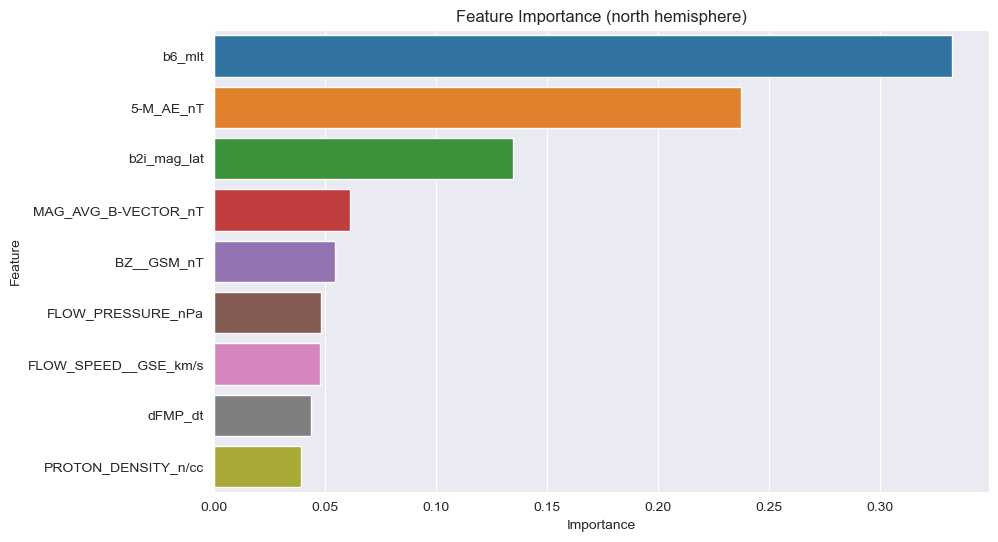


North Hemisphere Results:
               Model      RMSE       MAE        R²
0  Linear Regression  4.167654  3.224692  0.229218
1              Ridge  4.167656  3.224698  0.229217
2              Lasso  4.182842  3.247568  0.223590
3      Random Forest  3.285115  2.466217  0.521095
4                SVR  3.536488  2.636752  0.445000

Training Linear Regression...
Best parameters for Linear Regression: {}

Training Ridge...
Best parameters for Ridge: {'alpha': 10.0}

Training Lasso...
Best parameters for Lasso: {'alpha': 0.1}

Training Random Forest...


/Users/beastxgamer/anaconda3/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_parquet('data/5minData.parquet')
Northern = df['b6_mag_lat'] > 0
Southern = df['b6_mag_lat'] < 0
North_df = df[Northern]
South_df = df[Southern]

def evaluate_model(y_true, y_pred, model_name):
    """Calculate and return evaluation metrics for a model"""
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    return {
        'Model': model_name,
        'RMSE': rmse,
        'MAE': mae,
        'R²': r2
    }

def train_simple_models(df, hemisphere='north'):
    """
    Train and evaluate multiple simple ML models
    
    Parameters:
    df: DataFrame containing the data
    hemisphere: 'north' or 'south' to indicate which hemisphere's data
    """
    features = [
        'b6_mlt', 'MAG_AVG_B-VECTOR_nT', 'BZ__GSM_nT', 'FLOW_SPEED__GSE_km/s',
        'PROTON_DENSITY_n/cc', 'FLOW_PRESSURE_nPa', '5-M_AE_nT', 'dFMP_dt' , 'b2i_mag_lat'
    ]
    target = 'b6_mag_lat'
    
    # Prepare data
    df = df.dropna(subset=features + [target])
    X = df[features]
    y = df[target]
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
    
    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Initialize models with hyperparameter grids
    models = {
        'Linear Regression': {
            'model': LinearRegression(),
            'params': {}
        },
        'Ridge': {
            'model': Ridge(),
            'params': {
                'alpha': [0.1, 1.0, 10.0]
            }
        },
        'Lasso': {
            'model': Lasso(),
            'params': {
                'alpha': [0.1, 1.0, 10.0]
            }
        },
        'Random Forest': {
            'model': RandomForestRegressor(random_state=42),
            'params': {
                'n_estimators': [100, 200],
                'max_depth': [10, 20, None],
                'min_samples_split': [2, 5]
            }
        },
        'SVR': {
            'model': SVR(),
            'params': {
                'C': [0.1, 1.0, 10.0],
                'kernel': ['rbf', 'linear']
            }
        }
    }
    
    # Train and evaluate models
    results = []
    trained_models = {}
    
    for name, config in models.items():
        print(f"\nTraining {name}...")
        
        # Perform GridSearchCV
        grid_search = GridSearchCV(
            config['model'],
            config['params'],
            cv=5,
            scoring='neg_mean_squared_error',
            n_jobs=-1
        )
        
        grid_search.fit(X_train_scaled, y_train)
        best_model = grid_search.best_estimator_
        trained_models[name] = best_model
        
        # Make predictions
        y_pred = best_model.predict(X_test_scaled)
        
        # Calculate metrics
        metrics = evaluate_model(y_test, y_pred, name)
        results.append(metrics)
        
        print(f"Best parameters for {name}: {grid_search.best_params_}")
    
    # Convert results to DataFrame
    results_df = pd.DataFrame(results)
    
    # Visualize model comparisons
    plt.figure(figsize=(12, 6))
    
    # Plot RMSE comparison
    plt.subplot(1, 2, 1)
    sns.barplot(x='Model', y='RMSE', data=results_df)
    plt.xticks(rotation=45)
    plt.title(f'RMSE Comparison ({hemisphere} hemisphere)')
    
    # Plot R² comparison
    plt.subplot(1, 2, 2)
    sns.barplot(x='Model', y='R²', data=results_df)
    plt.xticks(rotation=45)
    plt.title(f'R² Comparison ({hemisphere} hemisphere)')
    
    plt.tight_layout()
    plt.show()
    
    # Feature importance analysis for Random Forest
    rf_model = trained_models['Random Forest']
    feature_importance = pd.DataFrame({
        'Feature': features,
        'Importance': rf_model.feature_importances_
    }).sort_values('Importance', ascending=False)
    
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Feature', data=feature_importance)
    plt.title(f'Feature Importance ({hemisphere} hemisphere)')
    plt.show()
    
    return results_df, trained_models, scaler

# Train models for both hemispheres
north_results, north_models, north_scaler = train_simple_models(North_df, 'north')
print("\nNorth Hemisphere Results:")
print(north_results)

south_results, south_models, south_scaler = train_simple_models(South_df, 'south')
print("\nSouth Hemisphere Results:")
print(south_results)

# Function to make predictions using all models
def predict_with_all_models(input_data, models, scaler):
    """Make predictions using all trained models"""
    scaled_input = scaler.transform(input_data)
    predictions = {}
    
    for name, model in models.items():
        pred = model.predict(scaled_input)
        predictions[name] = pred
        
    return predictions

# Example usage for a single data point
example_input = North_df[features].iloc[[0]]
north_predictions = predict_with_all_models(example_input, north_models, north_scaler)
print("\nPredictions for example input (North):")
for model_name, pred in north_predictions.items():
    print(f"{model_name}: {pred[0]:.2f}")

Training North Hemisphere Models...

Training Logistic Regression...


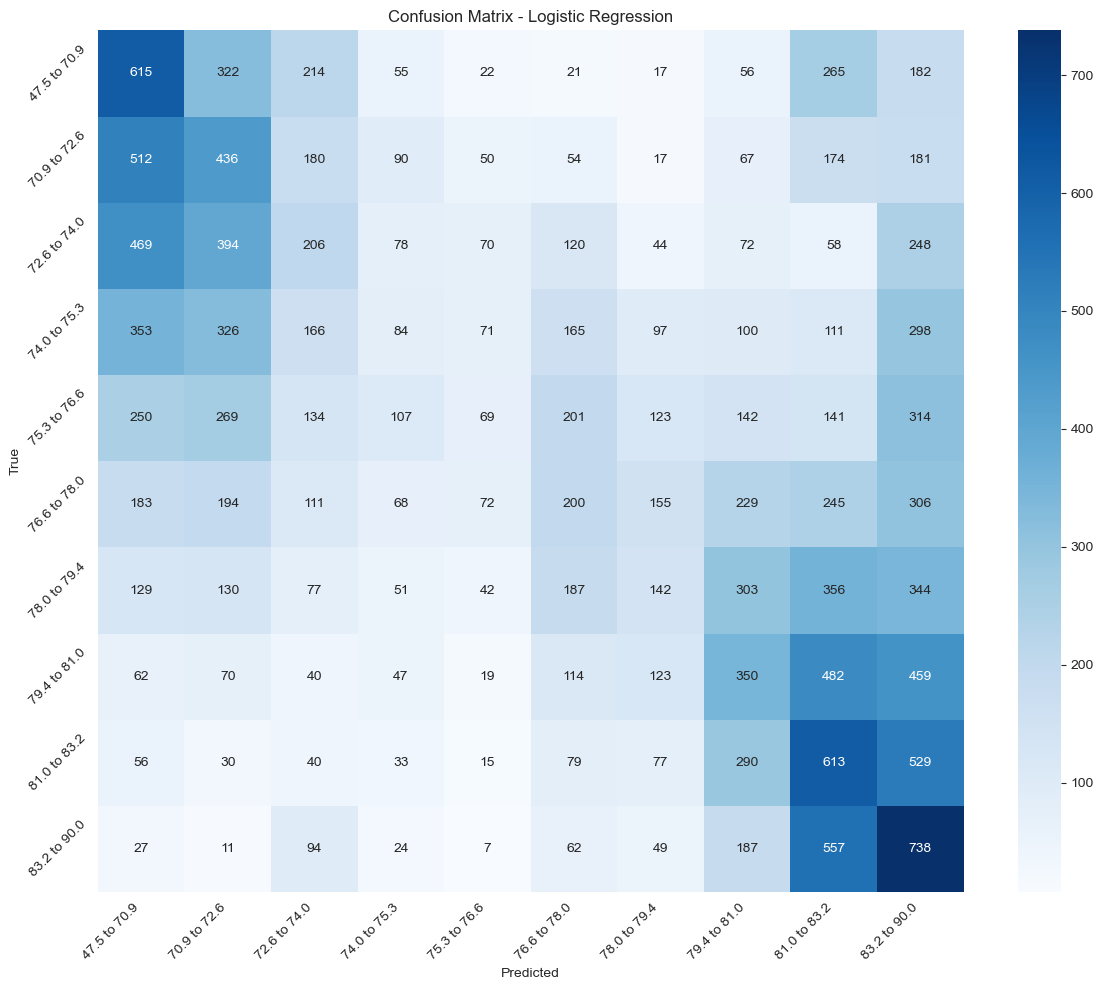

Best parameters for Logistic Regression: {'C': 0.1, 'solver': 'lbfgs'}

Classification Report:
              precision    recall  f1-score   support

47.5 to 70.9       0.23      0.35      0.28      1769
70.9 to 72.6       0.20      0.25      0.22      1761
72.6 to 74.0       0.16      0.12      0.14      1759
74.0 to 75.3       0.13      0.05      0.07      1771
75.3 to 76.6       0.16      0.04      0.06      1750
76.6 to 78.0       0.17      0.11      0.13      1763
78.0 to 79.4       0.17      0.08      0.11      1761
79.4 to 81.0       0.19      0.20      0.20      1766
81.0 to 83.2       0.20      0.35      0.26      1762
83.2 to 90.0       0.21      0.42      0.28      1756

    accuracy                           0.20     17618
   macro avg       0.18      0.20      0.17     17618
weighted avg       0.18      0.20      0.17     17618


Training Random Forest...


/Users/beastxgamer/anaconda3/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


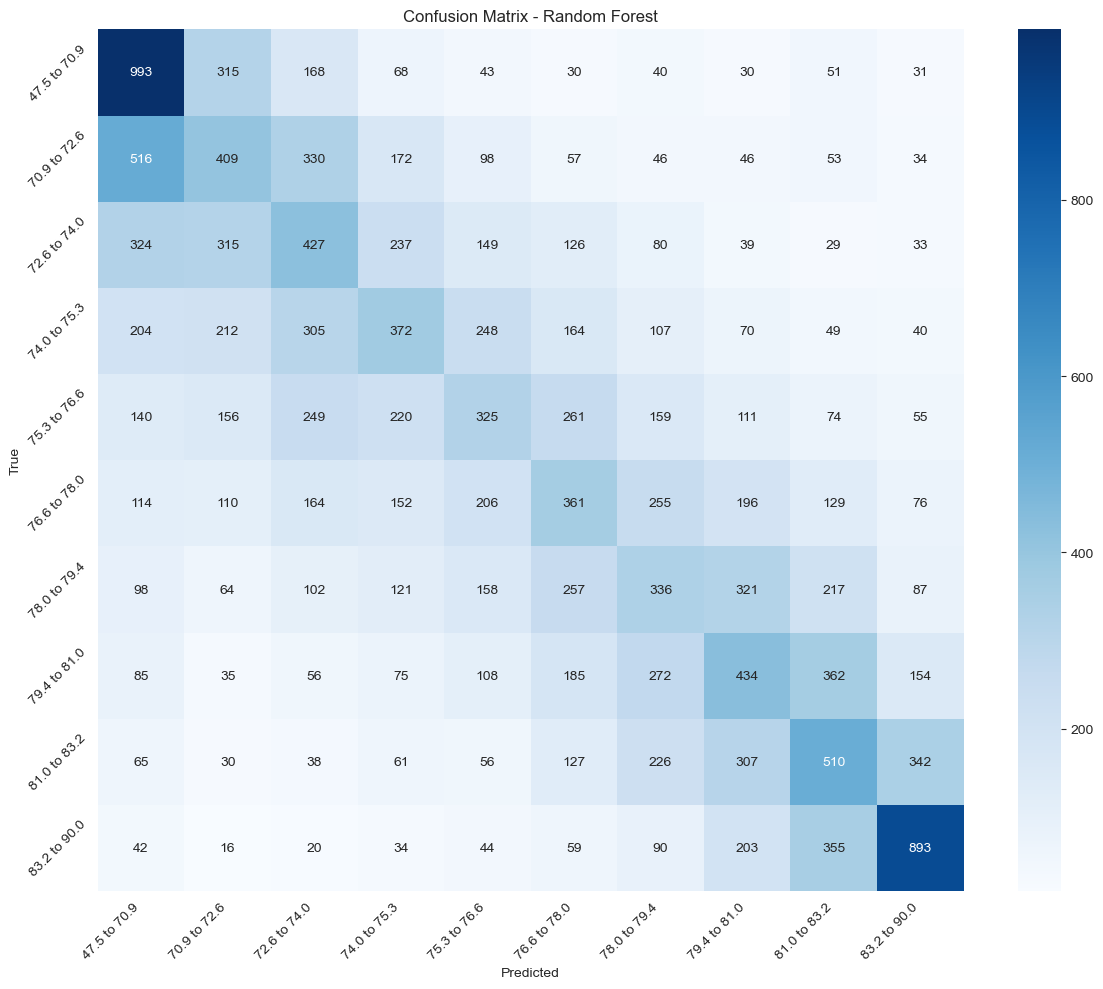

Best parameters for Random Forest: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 200}

Classification Report:
              precision    recall  f1-score   support

47.5 to 70.9       0.38      0.56      0.46      1769
70.9 to 72.6       0.25      0.23      0.24      1761
72.6 to 74.0       0.23      0.24      0.24      1759
74.0 to 75.3       0.25      0.21      0.23      1771
75.3 to 76.6       0.23      0.19      0.20      1750
76.6 to 78.0       0.22      0.20      0.21      1763
78.0 to 79.4       0.21      0.19      0.20      1761
79.4 to 81.0       0.25      0.25      0.25      1766
81.0 to 83.2       0.28      0.29      0.28      1762
83.2 to 90.0       0.51      0.51      0.51      1756

    accuracy                           0.29     17618
   macro avg       0.28      0.29      0.28     17618
weighted avg       0.28      0.29      0.28     17618


Training KNN...


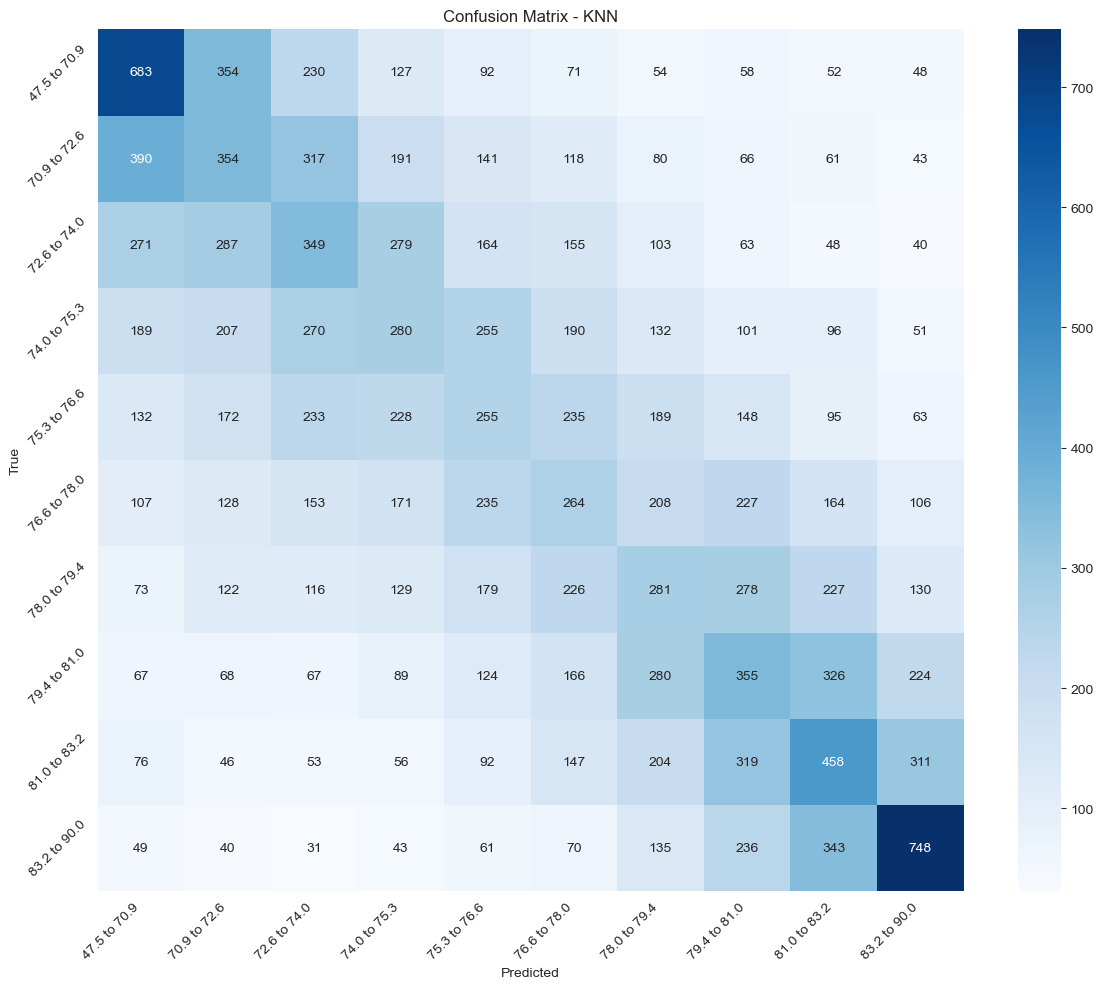

Best parameters for KNN: {'n_neighbors': 7, 'weights': 'distance'}

Classification Report:
              precision    recall  f1-score   support

47.5 to 70.9       0.34      0.39      0.36      1769
70.9 to 72.6       0.20      0.20      0.20      1761
72.6 to 74.0       0.19      0.20      0.20      1759
74.0 to 75.3       0.18      0.16      0.17      1771
75.3 to 76.6       0.16      0.15      0.15      1750
76.6 to 78.0       0.16      0.15      0.16      1763
78.0 to 79.4       0.17      0.16      0.16      1761
79.4 to 81.0       0.19      0.20      0.20      1766
81.0 to 83.2       0.24      0.26      0.25      1762
83.2 to 90.0       0.42      0.43      0.42      1756

    accuracy                           0.23     17618
   macro avg       0.23      0.23      0.23     17618
weighted avg       0.23      0.23      0.23     17618


Training Decision Tree...


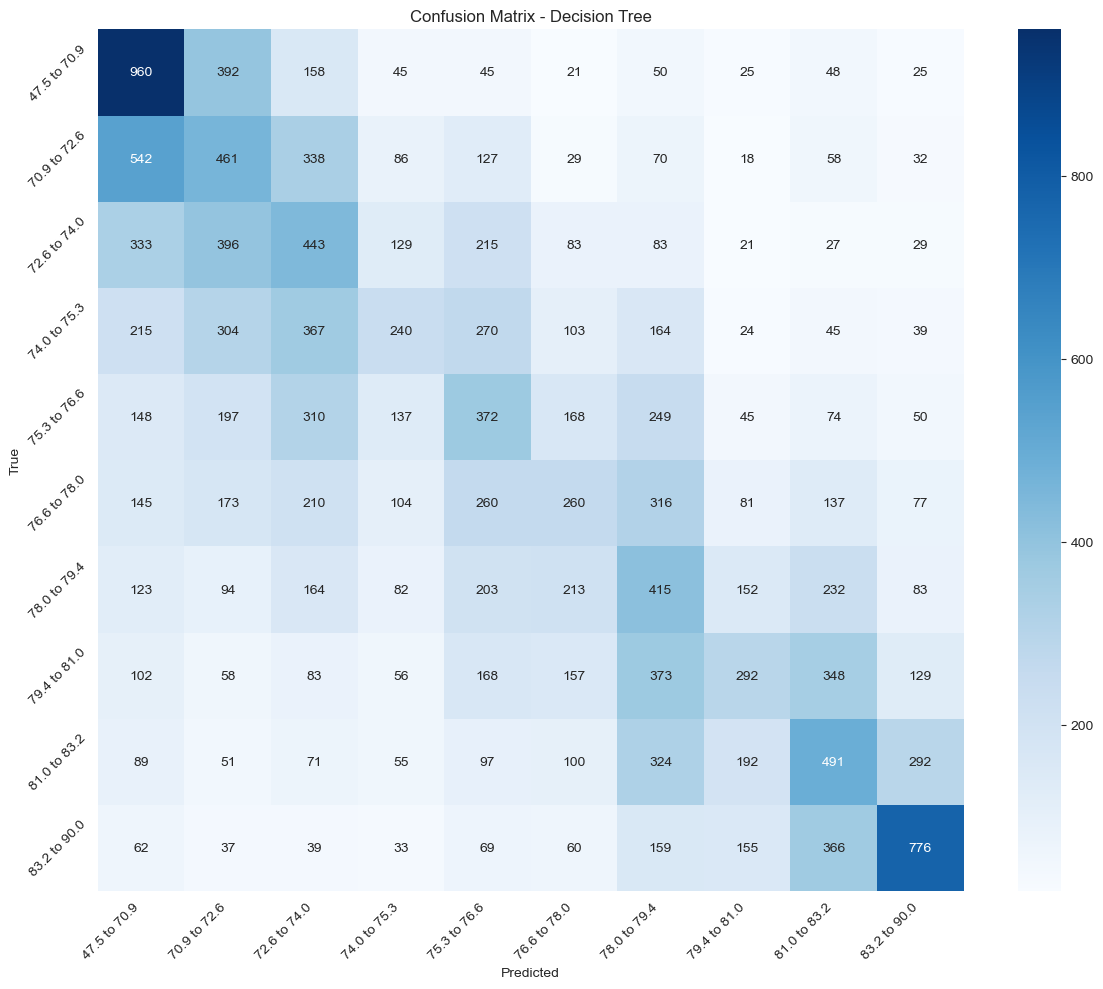

Best parameters for Decision Tree: {'max_depth': 10, 'min_samples_split': 2}

Classification Report:
              precision    recall  f1-score   support

47.5 to 70.9       0.35      0.54      0.43      1769
70.9 to 72.6       0.21      0.26      0.23      1761
72.6 to 74.0       0.20      0.25      0.22      1759
74.0 to 75.3       0.25      0.14      0.18      1771
75.3 to 76.6       0.20      0.21      0.21      1750
76.6 to 78.0       0.22      0.15      0.18      1763
78.0 to 79.4       0.19      0.24      0.21      1761
79.4 to 81.0       0.29      0.17      0.21      1766
81.0 to 83.2       0.27      0.28      0.27      1762
83.2 to 90.0       0.51      0.44      0.47      1756

    accuracy                           0.27     17618
   macro avg       0.27      0.27      0.26     17618
weighted avg       0.27      0.27      0.26     17618



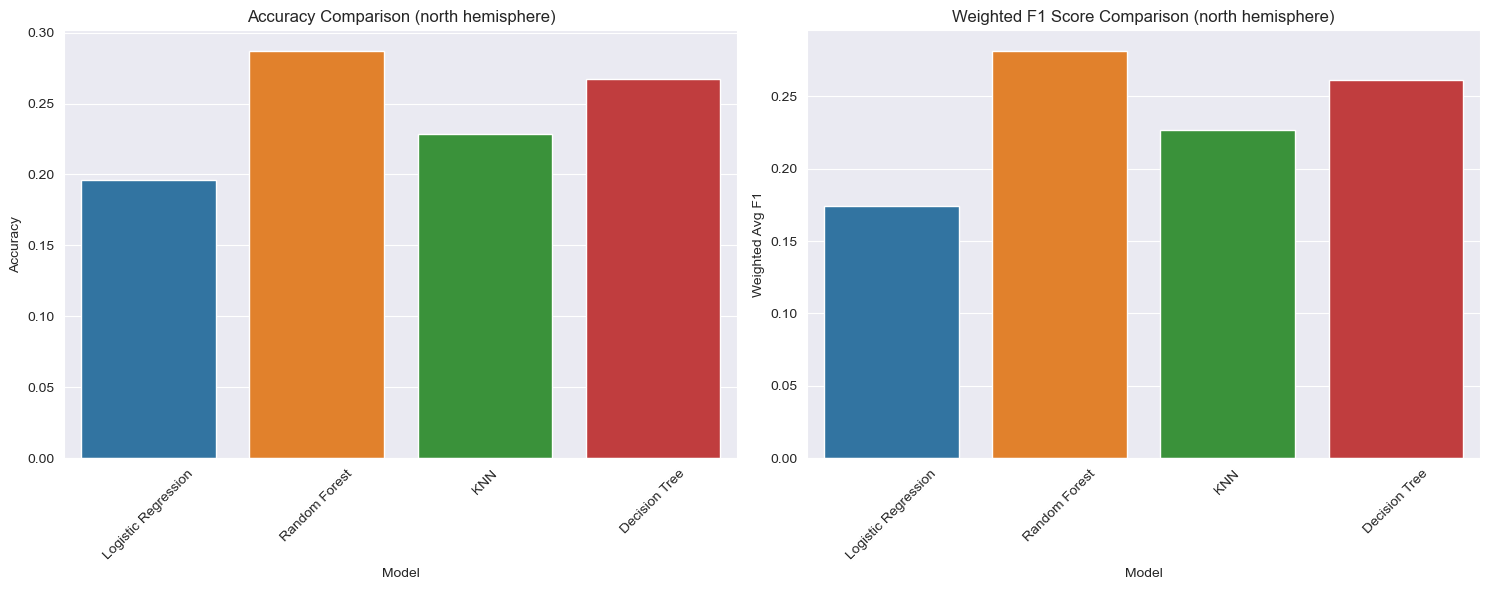

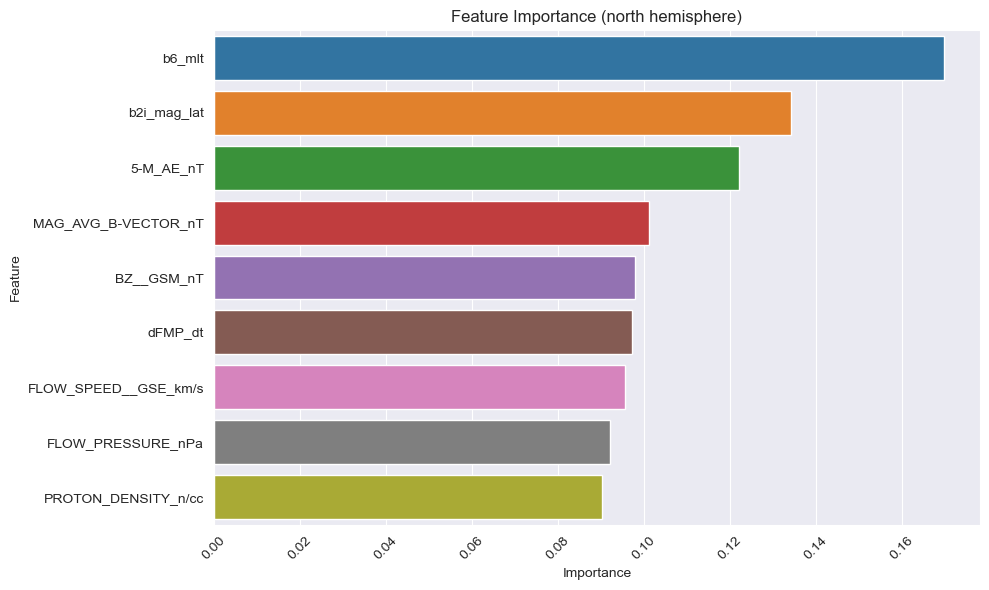

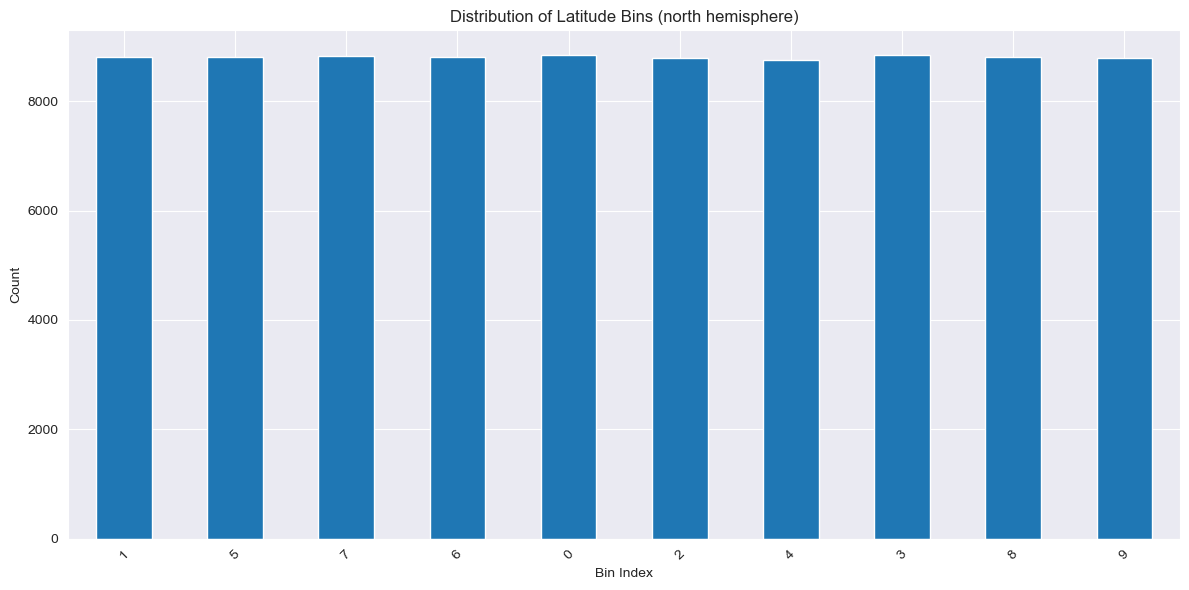


North Hemisphere Results:
                 Model  Accuracy  Macro Avg F1  Weighted Avg F1
0  Logistic Regression  0.195993      0.174174         0.174214
1        Random Forest  0.287206      0.281510         0.281529
2                  KNN  0.228573      0.226540         0.226544
3        Decision Tree  0.267340      0.261260         0.261241

Training South Hemisphere Models...

Training Logistic Regression...


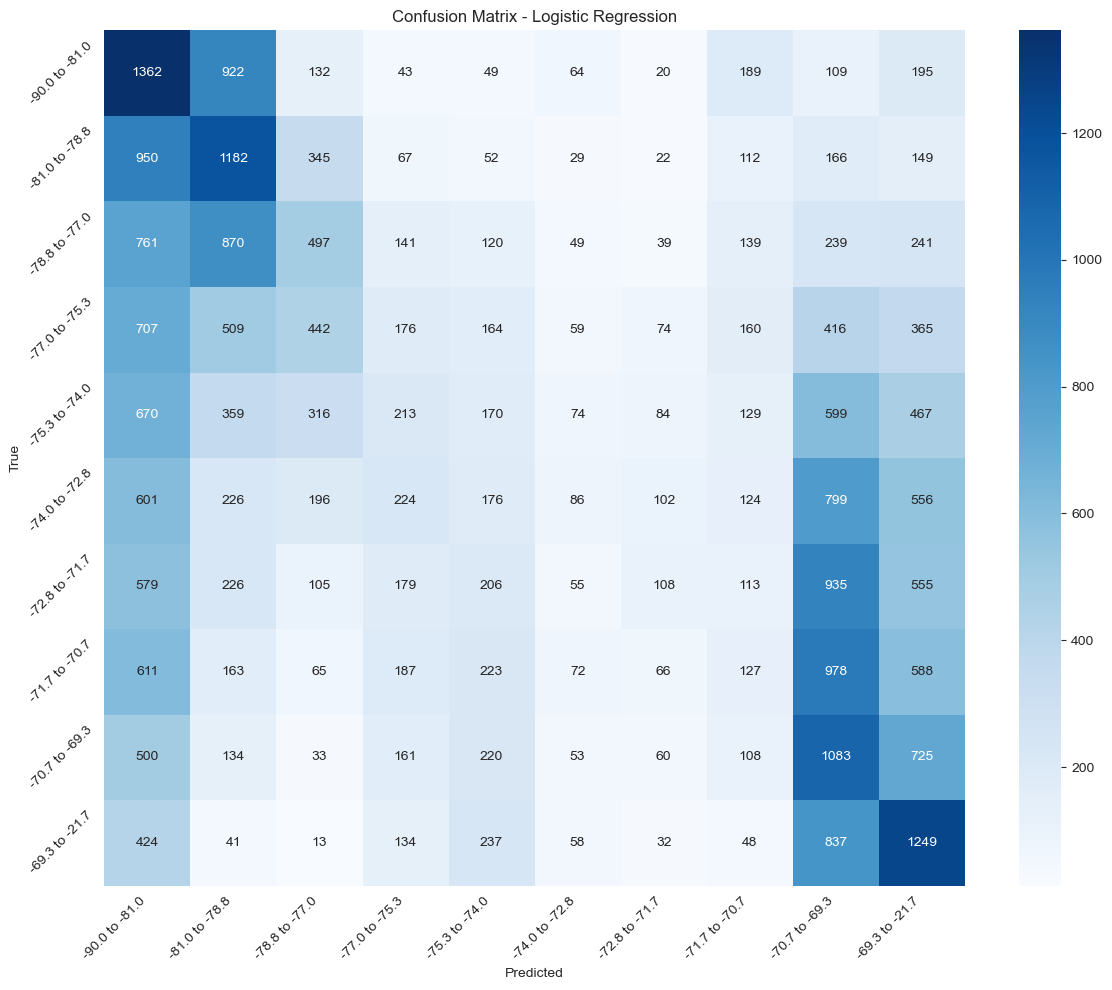

Best parameters for Logistic Regression: {'C': 10.0, 'solver': 'lbfgs'}

Classification Report:
                precision    recall  f1-score   support

-90.0 to -81.0       0.19      0.44      0.27      3085
-81.0 to -78.8       0.26      0.38      0.31      3074
-78.8 to -77.0       0.23      0.16      0.19      3096
-77.0 to -75.3       0.12      0.06      0.08      3072
-75.3 to -74.0       0.11      0.06      0.07      3081
-74.0 to -72.8       0.14      0.03      0.05      3090
-72.8 to -71.7       0.18      0.04      0.06      3061
-71.7 to -70.7       0.10      0.04      0.06      3080
-70.7 to -69.3       0.18      0.35      0.23      3077
-69.3 to -21.7       0.25      0.41      0.31      3073

      accuracy                           0.20     30789
     macro avg       0.17      0.20      0.16     30789
  weighted avg       0.17      0.20      0.16     30789


Training Random Forest...


/Users/beastxgamer/anaconda3/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


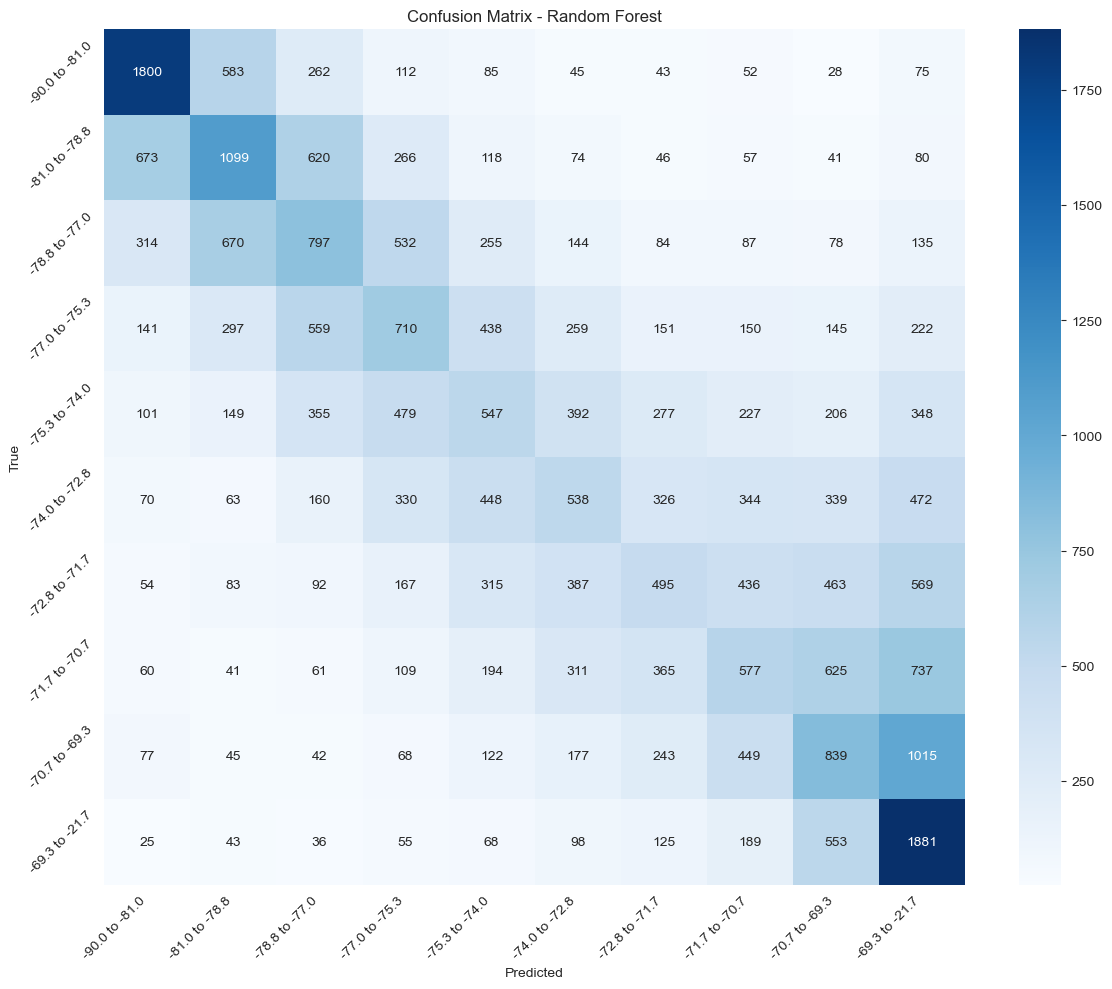

Best parameters for Random Forest: {'max_depth': 20, 'min_samples_split': 5, 'n_estimators': 200}

Classification Report:
                precision    recall  f1-score   support

-90.0 to -81.0       0.54      0.58      0.56      3085
-81.0 to -78.8       0.36      0.36      0.36      3074
-78.8 to -77.0       0.27      0.26      0.26      3096
-77.0 to -75.3       0.25      0.23      0.24      3072
-75.3 to -74.0       0.21      0.18      0.19      3081
-74.0 to -72.8       0.22      0.17      0.20      3090
-72.8 to -71.7       0.23      0.16      0.19      3061
-71.7 to -70.7       0.22      0.19      0.20      3080
-70.7 to -69.3       0.25      0.27      0.26      3077
-69.3 to -21.7       0.34      0.61      0.44      3073

      accuracy                           0.30     30789
     macro avg       0.29      0.30      0.29     30789
  weighted avg       0.29      0.30      0.29     30789


Training KNN...


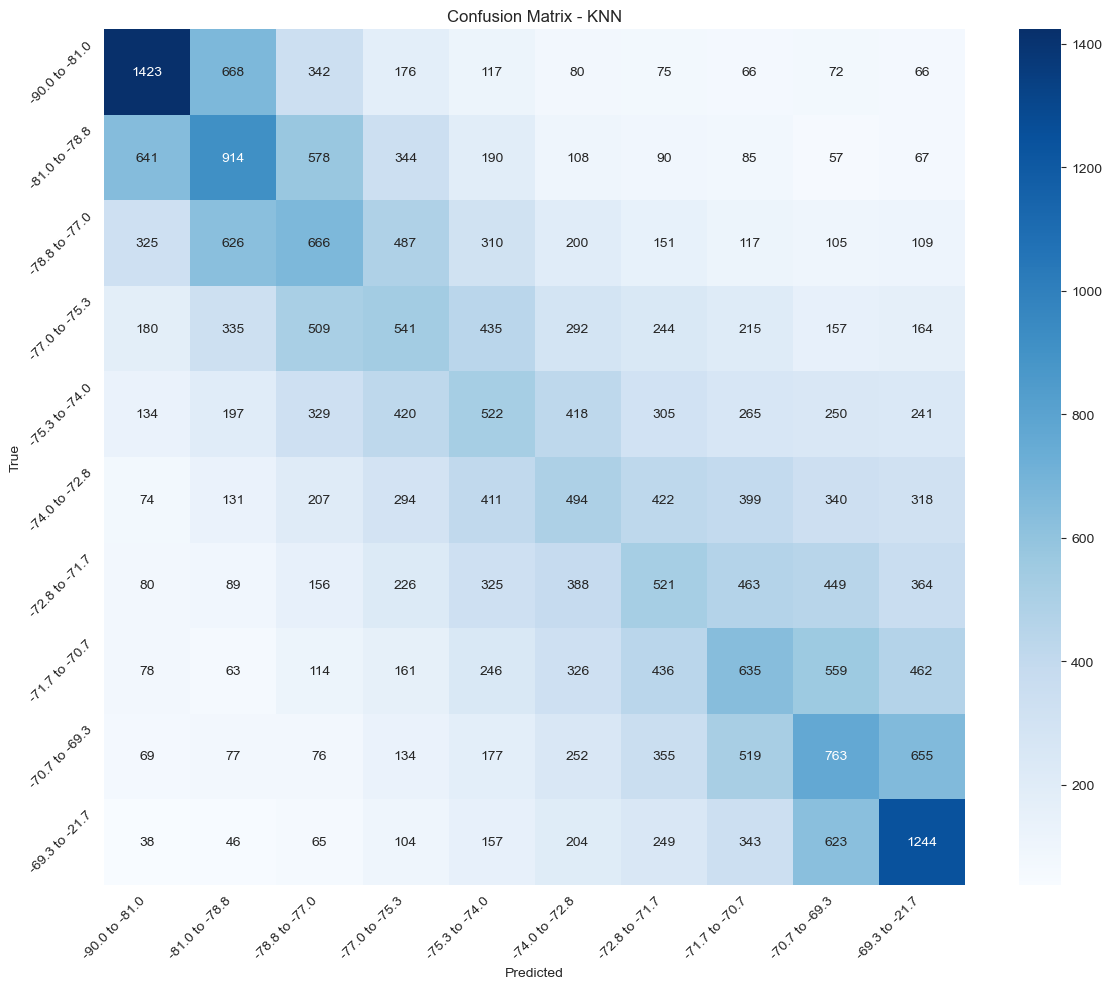

Best parameters for KNN: {'n_neighbors': 7, 'weights': 'distance'}

Classification Report:
                precision    recall  f1-score   support

-90.0 to -81.0       0.47      0.46      0.46      3085
-81.0 to -78.8       0.29      0.30      0.29      3074
-78.8 to -77.0       0.22      0.22      0.22      3096
-77.0 to -75.3       0.19      0.18      0.18      3072
-75.3 to -74.0       0.18      0.17      0.17      3081
-74.0 to -72.8       0.18      0.16      0.17      3090
-72.8 to -71.7       0.18      0.17      0.18      3061
-71.7 to -70.7       0.20      0.21      0.21      3080
-70.7 to -69.3       0.23      0.25      0.24      3077
-69.3 to -21.7       0.34      0.40      0.37      3073

      accuracy                           0.25     30789
     macro avg       0.25      0.25      0.25     30789
  weighted avg       0.25      0.25      0.25     30789


Training Decision Tree...


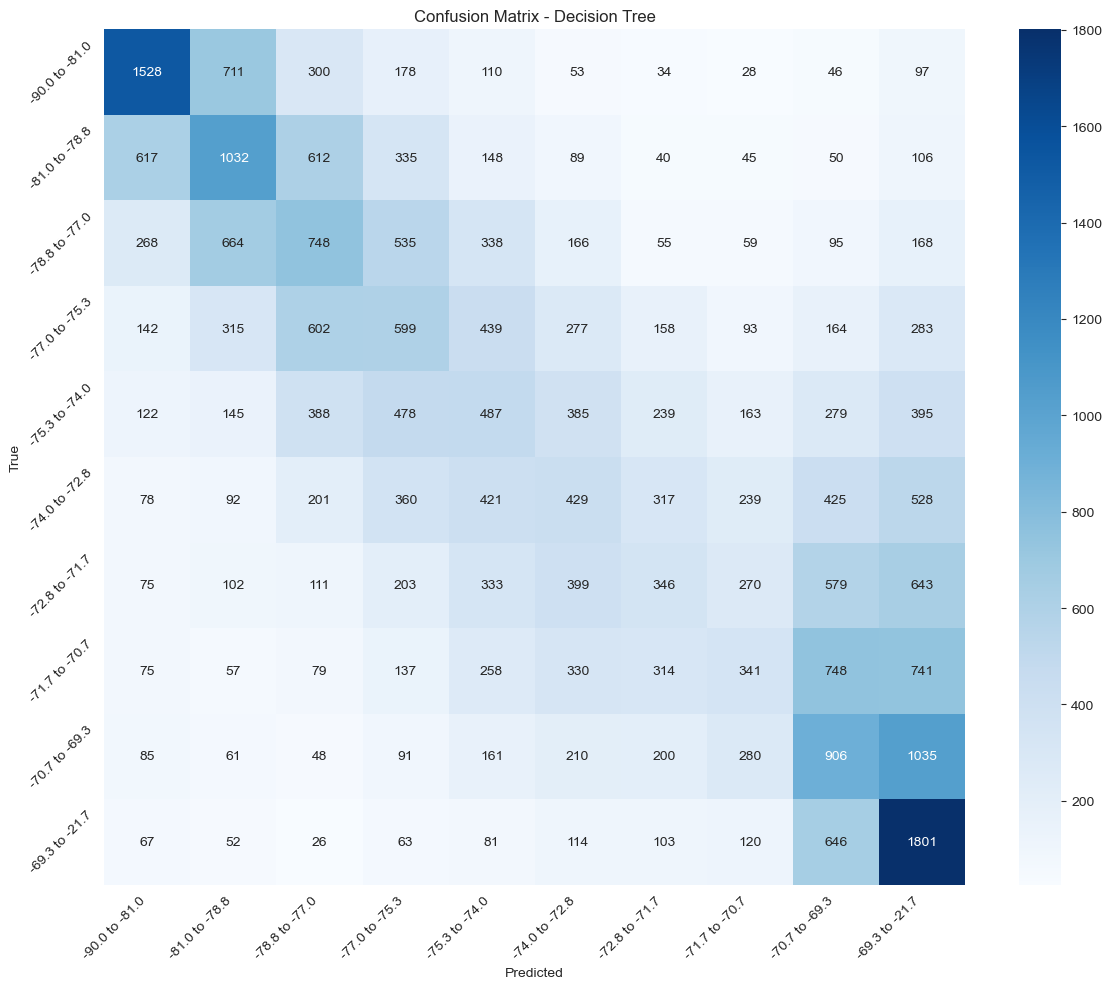

Best parameters for Decision Tree: {'max_depth': 10, 'min_samples_split': 2}

Classification Report:
                precision    recall  f1-score   support

-90.0 to -81.0       0.50      0.50      0.50      3085
-81.0 to -78.8       0.32      0.34      0.33      3074
-78.8 to -77.0       0.24      0.24      0.24      3096
-77.0 to -75.3       0.20      0.19      0.20      3072
-75.3 to -74.0       0.18      0.16      0.17      3081
-74.0 to -72.8       0.17      0.14      0.15      3090
-72.8 to -71.7       0.19      0.11      0.14      3061
-71.7 to -70.7       0.21      0.11      0.14      3080
-70.7 to -69.3       0.23      0.29      0.26      3077
-69.3 to -21.7       0.31      0.59      0.41      3073

      accuracy                           0.27     30789
     macro avg       0.26      0.27      0.25     30789
  weighted avg       0.26      0.27      0.25     30789



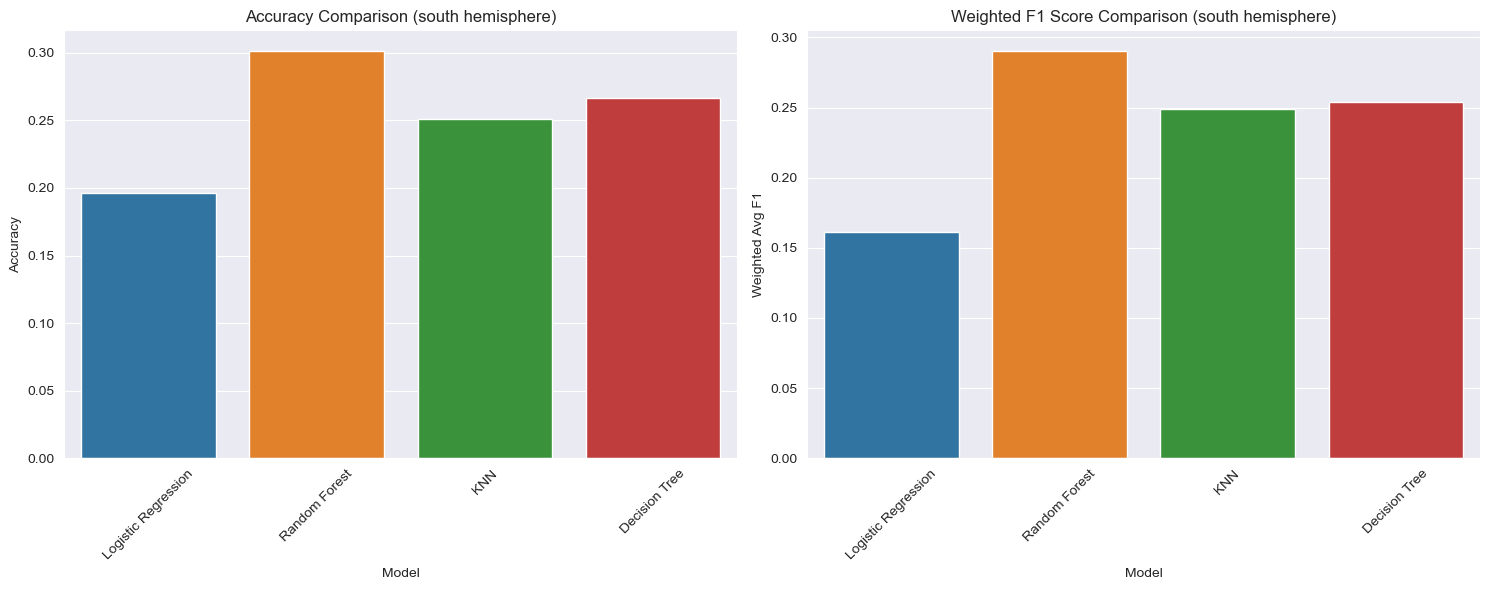

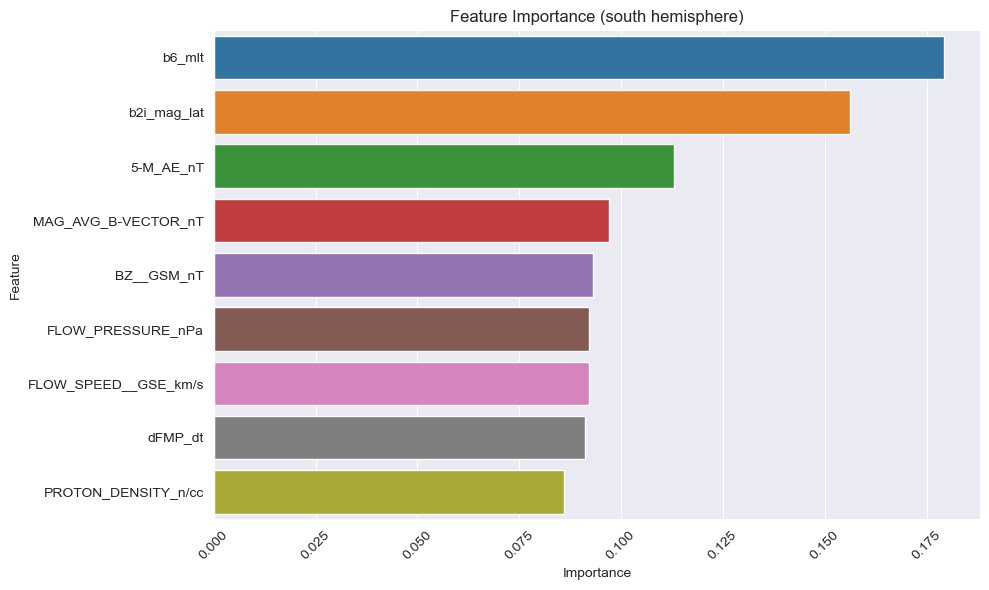

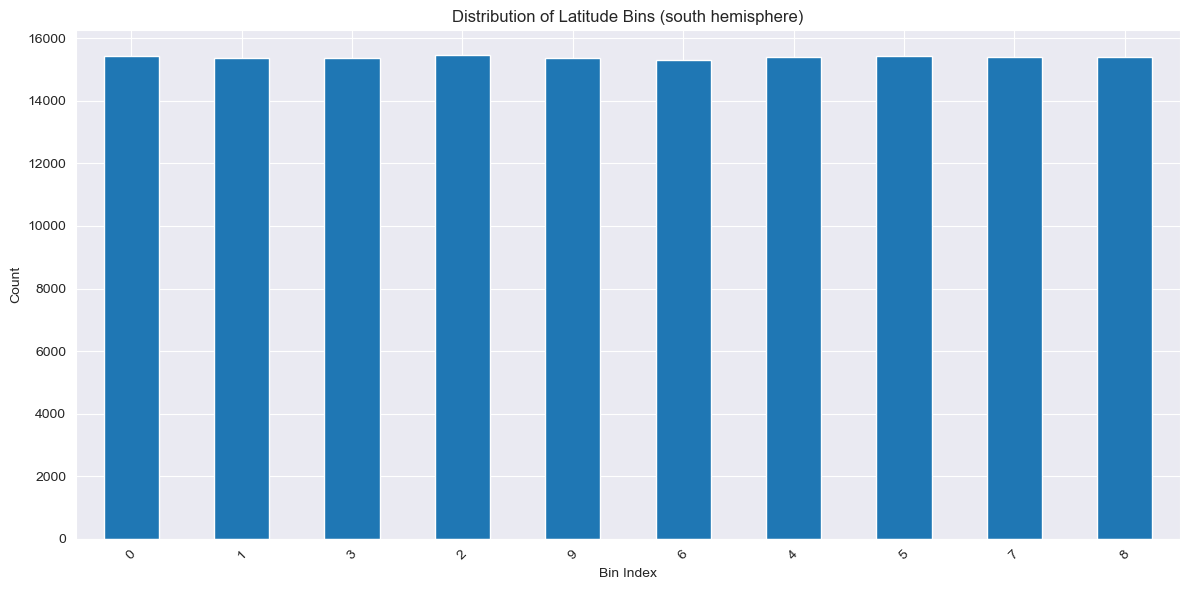


South Hemisphere Results:
                 Model  Accuracy  Macro Avg F1  Weighted Avg F1
0  Logistic Regression  0.196174      0.161584         0.161592
1        Random Forest  0.301504      0.290458         0.290484
2                  KNN  0.250836      0.248666         0.248684
3        Decision Tree  0.266881      0.253600         0.253632

Predictions for example input (North):
Logistic Regression: 81.0 to 83.2
Random Forest: 70.9 to 72.6
KNN: 70.9 to 72.6
Decision Tree: 81.0 to 83.2


In [5]:
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def create_latitude_bins(y, n_bins=10):
    """
    Create latitude bins with approximately equal number of samples in each bin
    """
    # Get bin edges using quantiles
    _, bin_edges = pd.qcut(y, q=n_bins, retbins=True, duplicates='drop')
    
    # Create bin labels
    bin_labels = [f"{bin_edges[i]:.1f} to {bin_edges[i+1]:.1f}" 
                 for i in range(len(bin_edges)-1)]
    
    # Assign data points to bins
    bins = pd.cut(y, bins=bin_edges, labels=False, include_lowest=True)
    
    return bins, bin_labels, bin_edges

def evaluate_classifier(y_true, y_pred, model_name):
    """Calculate and return evaluation metrics for a classification model"""
    accuracy = accuracy_score(y_true, y_pred)
    report = classification_report(y_true, y_pred, output_dict=True)
    
    return {
        'Model': model_name,
        'Accuracy': accuracy,
        'Macro Avg F1': report['macro avg']['f1-score'],
        'Weighted Avg F1': report['weighted avg']['f1-score']
    }

def plot_confusion_matrix(y_true, y_pred, classes, model_name):
    """Plot confusion matrix for the classifier"""
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=classes, yticklabels=classes)
    plt.title(f'Confusion Matrix - {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

def train_classification_models(df, hemisphere='north', n_bins=10):
    """
    Train and evaluate multiple classification models
    """
    features = [
        'b2i_mag_lat', 'b6_mlt', 'MAG_AVG_B-VECTOR_nT', 'BZ__GSM_nT', 'FLOW_SPEED__GSE_km/s',
        'PROTON_DENSITY_n/cc', 'FLOW_PRESSURE_nPa', '5-M_AE_nT', 'dFMP_dt'
    ]
    target = 'b6_mag_lat'
    
    # Prepare data
    df = df.dropna(subset=features + [target])
    X = df[features]
    y = df[target]
    
    # Create bins for latitude values
    y_binned, bin_labels, bin_edges = create_latitude_bins(y, n_bins)
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y_binned, test_size=0.2, random_state=42, stratify=y_binned
    )
    
    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Initialize models with hyperparameter grids
    models = {
        'Logistic Regression': {
            'model': LogisticRegression(max_iter=1000),
            'params': {
                'C': [0.1, 1.0, 10.0],
                'solver': ['lbfgs', 'liblinear']
            }
        },
        'Random Forest': {
            'model': RandomForestClassifier(random_state=42),
            'params': {
                'n_estimators': [100, 200],
                'max_depth': [10, 20, None],
                'min_samples_split': [2, 5]
            }
        },
        'KNN': {
            'model': KNeighborsClassifier(),
            'params': {
                'n_neighbors': [3, 5, 7],
                'weights': ['uniform', 'distance']
            }
        },
        'Decision Tree': {
            'model': DecisionTreeClassifier(random_state=42),
            'params': {
                'max_depth': [10, 20, None],
                'min_samples_split': [2, 5]
            }
        }
    }
    
    # Train and evaluate models
    results = []
    trained_models = {}
    
    for name, config in models.items():
        print(f"\nTraining {name}...")
        
        # Perform GridSearchCV
        grid_search = GridSearchCV(
            config['model'],
            config['params'],
            cv=5,
            scoring='accuracy',
            n_jobs=-1
        )
        
        grid_search.fit(X_train_scaled, y_train)
        best_model = grid_search.best_estimator_
        trained_models[name] = best_model
        
        # Make predictions
        y_pred = best_model.predict(X_test_scaled)
        
        # Calculate metrics
        metrics = evaluate_classifier(y_test, y_pred, name)
        results.append(metrics)
        
        # Plot confusion matrix
        plot_confusion_matrix(y_test, y_pred, bin_labels, name)
        
        print(f"Best parameters for {name}: {grid_search.best_params_}")
        print("\nClassification Report:")
        print(classification_report(y_test, y_pred, target_names=bin_labels))
    
    # Convert results to DataFrame
    results_df = pd.DataFrame(results)
    
    # Plot model performance comparisons
    plt.figure(figsize=(15, 6))
    
    plt.subplot(1, 2, 1)
    sns.barplot(x='Model', y='Accuracy', data=results_df)
    plt.xticks(rotation=45)
    plt.title(f'Accuracy Comparison ({hemisphere} hemisphere)')
    
    plt.subplot(1, 2, 2)
    sns.barplot(x='Model', y='Weighted Avg F1', data=results_df)
    plt.xticks(rotation=45)
    plt.title(f'Weighted F1 Score Comparison ({hemisphere} hemisphere)')
    
    plt.tight_layout()
    plt.show()
    
    # Analyze feature importance for Random Forest
    rf_model = trained_models['Random Forest']
    feature_importance = pd.DataFrame({
        'Feature': features,
        'Importance': rf_model.feature_importances_
    }).sort_values('Importance', ascending=False)
    
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Feature', data=feature_importance)
    plt.title(f'Feature Importance ({hemisphere} hemisphere)')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    # Plot distribution of bins
    plt.figure(figsize=(12, 6))
    pd.Series(y_binned).value_counts(sort=False).plot(kind='bar')
    plt.title(f'Distribution of Latitude Bins ({hemisphere} hemisphere)')
    plt.xlabel('Bin Index')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    return results_df, trained_models, scaler, bin_edges, bin_labels

def predict_class_with_all_models(input_data, models, scaler, bin_edges, bin_labels):
    """Make classification predictions using all trained models"""
    scaled_input = scaler.transform(input_data)
    predictions = {}
    
    for name, model in models.items():
        pred_bin = model.predict(scaled_input)[0]
        predictions[name] = bin_labels[pred_bin]
        
    return predictions

# Example usage
print("Training North Hemisphere Models...")
north_results, north_models, north_scaler, north_edges, north_labels = train_classification_models(
    North_df, 'north', n_bins=10
)
print("\nNorth Hemisphere Results:")
print(north_results)

print("\nTraining South Hemisphere Models...")
south_results, south_models, south_scaler, south_edges, south_labels = train_classification_models(
    South_df, 'south', n_bins=10
)
print("\nSouth Hemisphere Results:")
print(south_results)

# Example prediction
features = [
        'b2i_mag_lat', 'b6_mlt', 'MAG_AVG_B-VECTOR_nT', 'BZ__GSM_nT', 'FLOW_SPEED__GSE_km/s',
        'PROTON_DENSITY_n/cc', 'FLOW_PRESSURE_nPa', '5-M_AE_nT', 'dFMP_dt'
    ]
example_input = North_df[features].iloc[[0]]
north_predictions = predict_class_with_all_models(
    example_input, north_models, north_scaler, north_edges, north_labels
)
print("\nPredictions for example input (North):")
for model_name, pred in north_predictions.items():
    print(f"{model_name}: {pred}")